# Predicting tags on Stack Overflow's Python questions

## Problem definition

The goal of this model is to predict which tags beyond python
can be assigned to a given python question.

## Dataset used

The dataset used on this model comes from the official Stack Overflow contains only python
questions from 2015, that contains the title, body and assigned tags.

The query used to fetch the data can be accessed [here](https://data.stackexchange.com/stackoverflow/query/1317705).


### Below there's a overview of how the dataset looks

In [20]:
import pandas as pd


df = pd.read_csv("QueryResultsIsPandas.csv", sep=",")
df.head(3)

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,...,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate,ContentLicense,isPandas
0,33054527,1,33054552.0,NaN,2015-10-10 13:28:09,NaN,648,1269290,<p>I've very recently migrated to Py 3.5.\nThi...,1656343.0,...,2020-09-12 09:40:46,"TypeError: a bytes-like object is required, no...",<python><python-3.x><string><file><byte>,9,4,101.0,NaN,NaN,CC BY-SA 4.0,0
1,29846087,1,NaN,NaN,2015-04-24 11:16:44,NaN,271,772140,<p>I've installed Python 3.5 and while running...,268598.0,...,2020-10-23 23:33:38,Microsoft Visual C++ 14.0 is required (Unable ...,<python><python-3.x><visual-c++>,30,11,121.0,NaN,NaN,CC BY-SA 4.0,0
2,42339876,1,42340744.0,NaN,2017-02-20 08:43:18,NaN,187,629114,"<p><a href=""https://github.com/affinelayer/pix...",7580060.0,...,2020-09-23 23:09:28,error UnicodeDecodeError: 'utf-8' codec can't ...,<python><python-3.x><utf-8>,17,0,41.0,NaN,NaN,CC BY-SA 3.0,0


## Exploratory Analysis

Body length distribution:

/home/eduardo/PycharmProjects/DataMining/venv/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


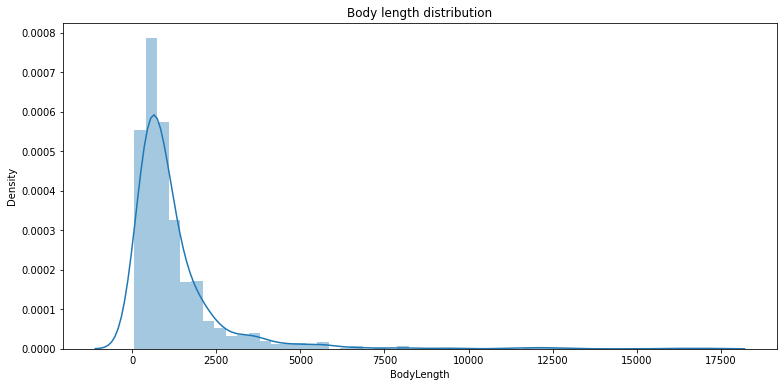

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns


df['BodyLength'] = df['Body'].str.len()

plt.figure(figsize=(12.8,6))
sns.distplot(df['BodyLength']).set_title('Body length distribution');

From the body length distribution plot, the majority of the questions body
has less than 5000 characters, so let's focus on the first 95% percentile.

/home/eduardo/PycharmProjects/DataMining/venv/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


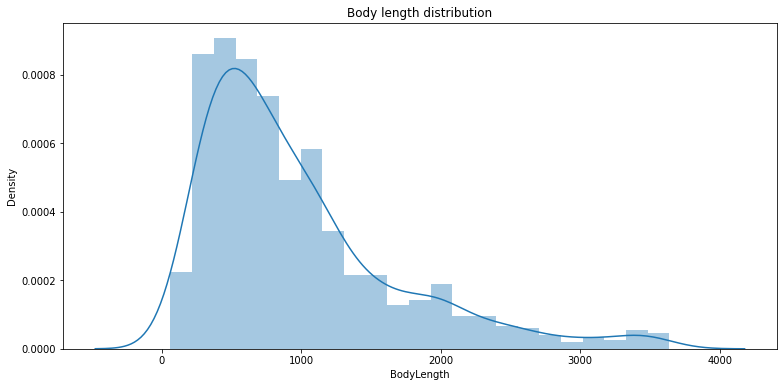

In [22]:
quantile_95 = df['BodyLength'].quantile(0.95)
df_95 = df[df['BodyLength'] < quantile_95]
plt.figure(figsize=(12.8,6))
sns.distplot(df_95['BodyLength']).set_title('Body length distribution');

In [23]:
## Text Cleaning


In [24]:
import re

# Multiple spaces Regex
SPACE_RE = re.compile(r'\s+')

# HTML Regex
HTML_RE = re.compile(r'<[^>]+>')

def clean_body(text):

    # Replace multiple spaces with single space
    text = SPACE_RE.sub(" ", text)

    # Remove HTML tags
    text = HTML_RE.sub("", text)

    # Removes new line character
    text = text.replace("\r", " ")    # Mac before OS X
    text = text.replace("\n", " ")    # Linux / Max OS X
    text = text.replace("\r\n", " ")  # Windows

    # Remove punctuation signs
    text = text.replace("?:!.,;", " ")

    # Remove all the special characters
    text = re.sub(r'\W', " ", text)

    # Remove possessive pronouns
    text = text.replace("'s", "")

    # Converting to Lowercase
    text = text.lower()

    return text


def clean_tags(text: str):
    # Remove opening tag character
    text = text.replace('<', "")

    # Crete a list of tags
    # using the closing tag character
    tags_list = text.split(">")

    return tuple(tags_list[:-1])

# Clean texts of the dataframe columns
df['Body'] = df['Body'].apply(clean_body)
df['Tags'] = df['Tags'].apply(clean_tags)

df.head(3)

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,...,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate,ContentLicense,isPandas,BodyLength
0,33054527,1,33054552.0,NaN,2015-10-10 13:28:09,NaN,648,1269290,i ve very recently migrated to py 3 5 this co...,1656343.0,...,"TypeError: a bytes-like object is required, no...","(python, python-3.x, string, file, byte)",9,4,101.0,NaN,NaN,CC BY-SA 4.0,0,787
1,29846087,1,NaN,NaN,2015-04-24 11:16:44,NaN,271,772140,i ve installed python 3 5 and while running p...,268598.0,...,Microsoft Visual C++ 14.0 is required (Unable ...,"(python, python-3.x, visual-c++)",30,11,121.0,NaN,NaN,CC BY-SA 4.0,0,690
2,42339876,1,42340744.0,NaN,2017-02-20 08:43:18,NaN,187,629114,https github com affinelayer pix2pix tensorf...,7580060.0,...,error UnicodeDecodeError: 'utf-8' codec can't ...,"(python, python-3.x, utf-8)",17,0,41.0,NaN,NaN,CC BY-SA 3.0,0,1007


### Dealing with the categories list

Since there's hundreds of possible categories,
another query was created to fetch them from the database.

This dataset contains a single column with all categories
that appears on the the questions dataset.

The query can be found [here](https://data.stackexchange.com/stackoverflow/query/1320614/all-tags-used-with-python).


In [25]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


# Split the dataset into training and validation datasets
train_x, test_x, train_y, test_y  = train_test_split(df["Body"], df["isPandas"], test_size=0.15)

# Label encode the target variable
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
test_y = encoder.fit_transform(test_y)

tfidf = TfidfVectorizer(analyzer='word', stop_words= 'english', max_features=500)

features_train = tfidf.fit_transform(train_x).toarray()
features_test = tfidf.fit_transform(test_x).toarray()

labels_train = train_y
labels_test = test_y

print(features_train.shape)
print(labels_test.shape)

(850, 500)
(150,)


## Random Forest


In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

rfc = RandomForestClassifier()

rfc.fit(features_train, labels_train)
rfc_pred = rfc.predict(features_test)

# Training accuracy
print("\nThe training accuracy is: ")
print(accuracy_score(labels_train, rfc.predict(features_train)))


# Test accuracy
print("\nThe test accuracy is: ")
print(accuracy_score(labels_test, rfc_pred))

# Classification report
print("\nClassification report")
print(classification_report(labels_test,rfc_pred))

print(confusion_matrix(labels_test, rfc_pred))


The training accuracy is: 
1.0

The test accuracy is: 
0.9666666666666667

Classification report
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       145
           1       0.00      0.00      0.00         5

    accuracy                           0.97       150
   macro avg       0.48      0.50      0.49       150
weighted avg       0.93      0.97      0.95       150

[[145   0]
 [  5   0]]


/home/eduardo/PycharmProjects/DataMining/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
